In [107]:
# Wed 17:10 
# Creates rectangle "depth images", a CNN, solves, and graphs the losses (by epoch)
# as well as the labels against the original image, and the true image (with x's)
# nrw
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


In [42]:

IMG_X, IMG_Y = 400,300
# length and width of blocks (fixed for now)
block_l, block_w = 25, 25
num_images = 50

# img_list = []
true_coords = []


# Calc rectangle vertices. makeRectangle() credit Sparkler, stackoverflow, feb 17
def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l/2.0, w/2.0), (l/2.0, -w/2.0), (-l/2.0, -w/2.0), (-l/2.0, w/2.0)]
    return [(c*x-s*y+offset[0], s*x+c*y+offset[1]) for (x, y) in rectCoords]


# ---- Make depth images ---
for i in range(num_images):
    orient = 0 # degrees
    img = Image.new('RGB', (IMG_X, IMG_Y), 'black')

    # block_l and _w offset so blocks don't run off edge of image
    rand_x = int(np.random.rand() * (IMG_X-block_l))
    rand_y = int(np.random.rand() * (IMG_Y-block_w))

    true_coords.append(np.array((rand_x, rand_y)))

    rect_vertices = makeRectangle(block_l, block_w, orient, offset=(rand_x,
                                                                    rand_y))
    idraw = ImageDraw.Draw(img)
    idraw.polygon(rect_vertices, fill='white')

    # use a truetype font
    #font = ImageFont.truetype("DejavuSans.ttf", 15)
    #font = ImageFont.truetype("Arial.ttf",14)
    #idraw.text((10, 25), '('+ str(rand_x) + ', ' + str(rand_y) +')')


    img.save('./data/rect'+str(i)+'.png')


    
class RectDepthImgsDataset(Dataset):
    """Artificially generated depth images dataset"""

    def __init__(self, img_dir, coords, transform=None):
        """
        """
        self.img_dir = img_dir
        self.true_coords = coords
        self.transform = transform

    def __len__(self):
        return len(self.true_coords)

    def __getitem__(self, idx):
        # image = self.images[idx]
        image = io.imread(self.img_dir + '/rect'+str(idx)+'.png')
        image = torch.FloatTensor(image).permute(2, 0, 1) #PIL and torch expect difft orders
        coords = torch.FloatTensor(true_coords[idx])

        if self.transform:
            image = self.transform(image)

        # sample = {'image': image, 'grasp': str(coords[0]) + str(coords[1])}
        sample = {'image': image, 'grasp': coords}
        sample = image, coords

        return sample

In [112]:
# Hyper parameters
num_epochs = 10 
num_classes = 2
batch_size = 4 
learning_rate = 0.001

# Dataset is depth images of rectangular blocks
train_dataset = RectDepthImgsDataset(img_dir='./data', coords=true_coords)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)

const = 16*47*47
#const = 16*97*72


# 300x300
#torch.Size([4, 300, 300, 3])
#torch.Size([4, 3, 300, 300])
#torch.Size([4, 6, 148, 148])
#torch.Size([4, 16, 72, 72])


# 200x200
#const = 16*47*47*4
#torch.Size([4, 200, 200, 3])
#torch.Size([4, 3, 200, 200])
#torch.Size([4, 6, 98, 98])
#torch.Size([4, 16, 47, 47])

# = 200-4 / 2
# where 4 = 5x5 (conv) -1 = area of image after conv without padding = 200->98
# = 98-4 / 2
# where 4 = 5x5 (conv) -1 = area of image after conv without padding = 98->47
# output is 47x47 image, with 16 output channels


# 400x300
#torch.Size([4, 300, 400, 3])
#torch.Size([4, 3, 400, 300])
#torch.Size([4, 6, 198, 148])
#torch.Size([4, 16, 97, 72])


class Net(nn.Module):  # CIFAR is 32x32x3, MNIST is 28x28x1)
    def __init__(self, IMG_X, IMG_Y):
        super(Net, self).__init__()
        self._imgx = IMG_X
        self._imgy = IMG_Y
        _pool = 2
        _stride = 5
        _outputlayers = 16
        
        def _calc(val):
            layer_size = (val- (_stride-1)) / _pool
            return layer_size 
        
        #print(self._imgx)
        self._const = _calc(_calc(self._imgx))
        self._const *= _calc(_calc(self._imgy))
        self._const *= _outputlayers 
        #print(self._const)
        self._const = int(self._const)
        
        self.conv1 = nn.Conv2d(3, 6, _stride)
        self.pool = nn.MaxPool2d(_pool, _pool)
        self.conv2 = nn.Conv2d(6, _outputlayers, _stride)
        self.fc1 = nn.Linear(self._const, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        

    def forward(self, x):
        #print(x.size())
        x = x.view(-1, 3, IMG_X, IMG_Y)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self._const)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net(IMG_X, IMG_Y)
images = iter(train_loader)
outputs = model(images.next()[0])

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [119]:
losses_list = []
print('Training model now...')
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i_batch, (images, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        if (i_batch+1) % 1 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1,
                                                                      num_epochs,
                                                                      i_batch+1,
                                                                      total_step,
                                                                      loss.item()))
            losses_list.append(loss.item())

Training model now...
Epoch [1/10], Step [1/13], Loss: 546.0654
Epoch [1/10], Step [2/13], Loss: 186.8227
Epoch [1/10], Step [3/13], Loss: 654.1339
Epoch [1/10], Step [4/13], Loss: 349.9690
Epoch [1/10], Step [5/13], Loss: 133.7014
Epoch [1/10], Step [6/13], Loss: 162.4137
Epoch [1/10], Step [7/13], Loss: 188.5582
Epoch [1/10], Step [8/13], Loss: 19.6055
Epoch [1/10], Step [9/13], Loss: 331.2300
Epoch [1/10], Step [10/13], Loss: 252.0109
Epoch [1/10], Step [11/13], Loss: 3122.6326
Epoch [1/10], Step [12/13], Loss: 643.8511
Epoch [1/10], Step [13/13], Loss: 33.2581
Epoch [2/10], Step [1/13], Loss: 215.4266
Epoch [2/10], Step [2/13], Loss: 173.0641
Epoch [2/10], Step [3/13], Loss: 173.9634
Epoch [2/10], Step [4/13], Loss: 642.3748
Epoch [2/10], Step [5/13], Loss: 576.8269
Epoch [2/10], Step [6/13], Loss: 208.5045
Epoch [2/10], Step [7/13], Loss: 127.1689
Epoch [2/10], Step [8/13], Loss: 43.7680
Epoch [2/10], Step [9/13], Loss: 679.9045
Epoch [2/10], Step [10/13], Loss: 101.7159
Epoch [2/

In [114]:
from IPython.display import display # to display images
def imshow_coord(img, a_label):
    img = torchvision.transforms.ToPILImage()(img)
    draw = ImageDraw.Draw(img)
    draw = draw_crosspointer(a_label, draw, 'green', 'white', length=8)
    display(img)
    
def draw_crosspointer(xy, draw, fillcolor_X='green', fillcolor='white', length=2):
    a,b = tuple(xy)
    draw.line((a-length, b+length, a+length, b-length), fill=fillcolor_X)
    draw.line((a-length, b-length, a+length, b+length), fill=fillcolor_X)
    draw.point((a,b))
    return draw

4
x,y truth tensor([109., 207.])
x,y guess by net tensor([109.4909, 214.5787]) 

image size:  torch.Size([3, 300, 400]) 

net output: 


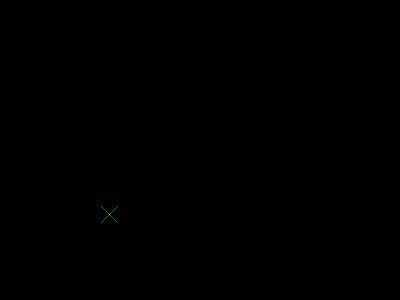

truth label: 


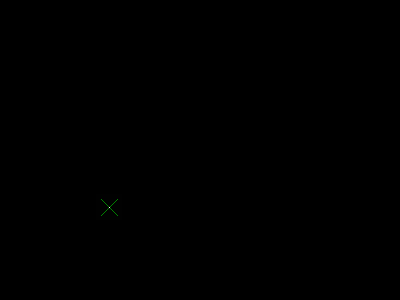

In [120]:
import torchvision 
import matplotlib.pyplot as plt
import copy
# get some random training images
with torch.no_grad():
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    outputs = model(images)
    
    # show images
    #imshow_coord(torchvision.utils.make_grid(images), (outputs))


    # print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  # for j in range(4)))
 
n =1 
print(len(labels))
print('x,y truth', labels[n])
print('x,y guess by net', outputs[n], '\n')

images_copy = copy.deepcopy(images)
print('image size: ', images_copy[n].size(), '\n')
print('net output: ')
imshow_coord(images_copy[n], outputs[n])
print('truth label: ')
imshow_coord(images_copy[n], labels[n])

#imagePIL = torchvision.transforms.ToPILImage()(images[n])
#print('PIL image size', imagePIL.size)
#imagePIL.save('test.png')
#display(imagePIL)

#display(Image.open('./data/rect'+str(n)+'.png'))

[  0  13  26  39  52  65  78  91 104 117]


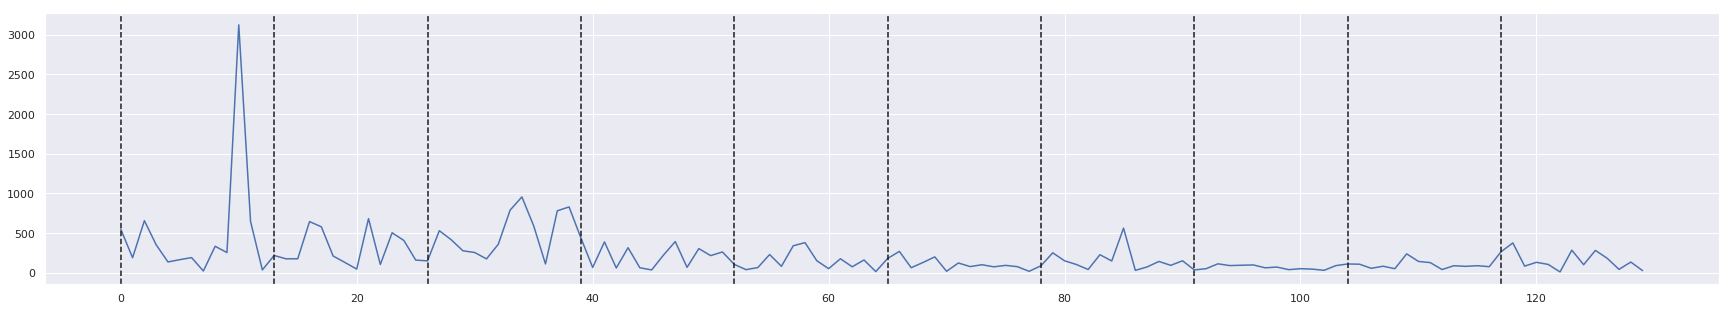

In [144]:
import seaborn as sns
sns.set()
f = plt.subplot()
f.plot(range(len(losses_list)), losses_list)

plt.rcParams['figure.figsize'] = [30, 5]
xposition = np.array(range(num_epochs))  * (total_step) 
print(xposition)
for xc in xposition:
    plt.axvline(x=xc, color='k', linestyle='--')

[225   9]
tensor([[239.9477,   8.5142]])


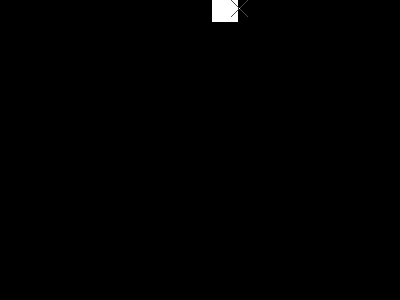

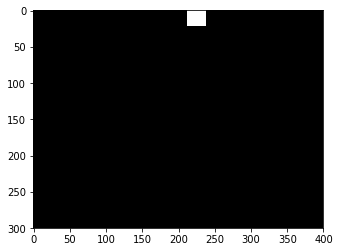

In [116]:
%matplotlib inline
#im = Image.open("Mew.jpg")
n = 5

image = io.imread('./data/rect'+str(n)+'.png')
image_tensor = torch.FloatTensor(image).permute(2, 0, 1) #PIL and torch expect difft orders
coords = torch.FloatTensor(true_coords[n])
with torch.no_grad():
    output = model(image_tensor)

print(true_coords[n])
print(output)
x,y = output.numpy().flatten()
imshow_coord(image, (x,y))
plt.imshow(image)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 300, 400])
tensor(255.) tensor(0.) torch.Size([3, 304, 1610])
(304, 1610, 3)
3


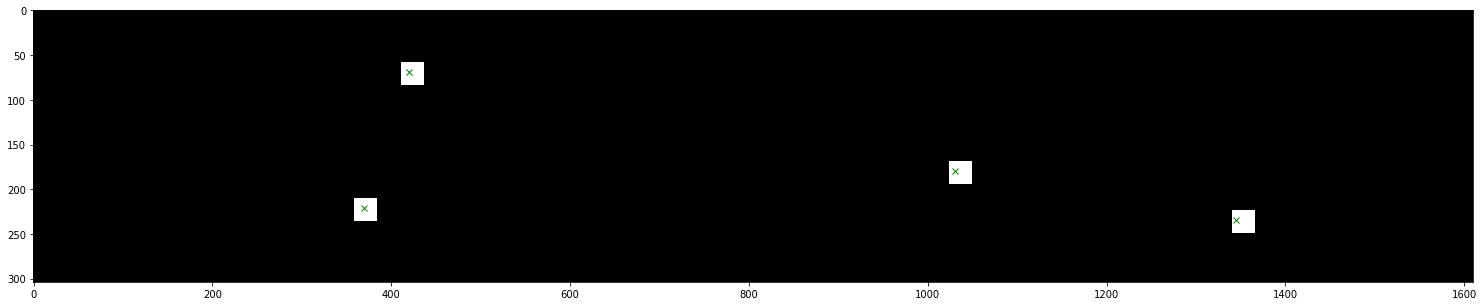

In [118]:
#img = Image.new('RGB', (300,400), 'gray')
n = 0
#imshow_coord(images[n], outputs[n], labels[n])

print(images.size())
a = torchvision.utils.make_grid(images)
print(a.max(), a.min(), a.size())
#a = a / 2 + 0.5     # unnormalize

a = a.numpy()
a = np.transpose(a,(1,2,0))
print(a.shape)
print(a.ndim)

#ran = a.max() - a.min()
#a = (a/ran )

plt.imshow(a)
#x,y = labels[0].numpy()
#plt.scatter(x,y, color='g', marker='x', linewidth='1')

plt.rcParams['figure.figsize'] = [30, 5]
for i in range(len(labels)):
    x,y = labels[i].numpy()
    plt.scatter(x + i*IMG_X,y, color='g', marker='x', linewidth='1')
#plt.imshow(np.transpose(a, (2,0,1)))